# Risk Based Authentication 

Trabalho Realizado por:

- Bernardo Coelho nº 98445
- Francisco Camilo nº99234
- Simão Miguel nº 99064
- Tiago Coelho nº 105176


A nossa base de dados escolhida é relativa a histórico de tentativas de login.
Foi definido ao longo do projeto que o objetivo seria determinar se um login poderia ser ou não um ataque de IP

Para tal fizemos 4 notebooks , cada um com objetivos diferente:
- Extract, transform and load (ETL)- neste notebook irá ser feita uma limpeza e tratamento, serão escolhidas as variáveis a utiizar para o modelo
- Análise exploratória-> neste notebook iremos verificar e analisar os dados
- Treino e afinação do modelo -> neste notebook irá ser criado o modelo para o objetivo final de determinar se se um login pode ser ou não um ataque de IP
- Deployment do modelo -> iremos ver os resultados do modelo


In [132]:
import pyspark
import pyspark.sql.functions as F 
from pyspark.sql import SparkSession
import ipaddress
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.window import Window
from pyspark.ml.feature import OneHotEncoder,StringIndexer,VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from scipy.stats import chi2_contingency
from pyspark.sql.functions import rand

In [72]:
# build our SparkSession

spark = SparkSession\
        .builder\
        .appName("BigData")\
        .config("spark.sql.shuffle.partitions",6)\
        .config("spark.sql.repl.eagereval.enabled",True)\
        .getOrCreate()

In [73]:
data_dir = "/home/jovyan/code/Datasets/rba-dataset.csv"

In [74]:
file_path = data_dir 
df = spark.read.csv(file_path, header="true", inferSchema="true", sep=',')

In [75]:
df.show()

+-----+--------------------+--------------------+--------------------+---------------+-------+-----------------+----------+------+--------------------+------------------------+--------------------+-----------+----------------+------------+-------------------+
|index|     Login Timestamp|             User ID|Round-Trip Time [ms]|     IP Address|Country|           Region|      City|   ASN|   User Agent String|Browser Name and Version| OS Name and Version|Device Type|Login Successful|Is Attack IP|Is Account Takeover|
+-----+--------------------+--------------------+--------------------+---------------+-------+-----------------+----------+------+--------------------+------------------------+--------------------+-----------+----------------+------------+-------------------+
|    0|2020-02-03 12:43:...|-4324475583306591935|                NULL|    10.0.65.171|     NO|                -|         -| 29695|Mozilla/5.0  (iPh...|     Firefox 20.0.0.1618|            iOS 13.4|     mobile|           

In [76]:
df.count()

31269264

Iremos agora realizar a transformção dos dados, fazendo as seguintes tarefas:
- Sampling dos dados
- Limpeza dos dados
- Criação de novas variáveis relevantes para o problema
- Observar a correlação das variáveis com a variável alvo , 'Is Attack IP'
- Codificar as variáveis para mais tarde implementá-las num modelo


# Sampling

In [77]:
df = df.sample(fraction=0.05, seed=42)

# Show the sampled DataFrame
df.count()

1563677

Decidimos então utilizar apenas uma porção da nossa base de dados,ficando então com 5% das iniciais.

# Limpeza

## Valores duplicados

In [78]:
df = df.dropDuplicates()
df.count()

1563677

Observamos que não existem valores duplicados

## Valores Omissos

In [79]:
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+---------------+-------+--------------------+----------+-------+------+----+---+-----------------+------------------------+-------------------+-----------+----------------+------------+-------------------+
|index|Login Timestamp|User ID|Round-Trip Time [ms]|IP Address|Country|Region|City|ASN|User Agent String|Browser Name and Version|OS Name and Version|Device Type|Login Successful|Is Attack IP|Is Account Takeover|
+-----+---------------+-------+--------------------+----------+-------+------+----+---+-----------------+------------------------+-------------------+-----------+----------------+------------+-------------------+
|    0|              0|      0|             1499769|         0|      0|  2311| 420|  0|                0|                       0|                  0|         70|               0|           0|                  0|
+-----+---------------+-------+--------------------+----------+-------+------+----+---+-----------------+------------------------+------------------

Observamos que variável 'Round-Trip Time [ms]' é praticamente composta por valores omissos.
Embora teoricamente seja uma variável que poderia ajudar muito o modelo , decidimos apagar!
Foram também apagadas outras variáveis:
- User Id: não traria qualquer valor;
- Region & City: Como já temos a variável relativamente ao país decidimos não colocar estas variáveis pois também apresentavam valores omissos;
- User Agent String: Já temos alguma da informação disponibilizada por esta coluna noutras colunas e de forma mais organizada. Uma vez que cada login irá dar um user agent string diferente , decidimos apagar
- Is Account Takeover: Como o nosso objetivo é relativo a ataques de Ip decidimos apagar

In [80]:
cols_to_drop = ["Round-Trip Time [ms]","User ID", "Region","City","User Agent String","Is Account Takeover"]                                                                                           
df = df.drop(*cols_to_drop)

In [81]:
df = df.na.drop(subset=["Device Type"])

# Criação de Variáveis

#### Tipo de IP (Publico ou Privado)

In [82]:
def classify_ip(ip):
    try:
        ip_obj = ipaddress.ip_address(ip)
        if ip_obj.is_private:
            return "Private"
        else:
            return "Public"
    except ValueError:
        return "Invalid IP Address"

# Register the function as a UDF
classify_ip_udf = udf(classify_ip, StringType())

# Apply the UDF to the DataFrame
df = df.withColumn("ip_classification", classify_ip_udf(df["IP Address"]))

In [83]:
(df
    .groupBy('ip_classification')
    .count()
    .show()
)

+-----------------+-------+
|ip_classification|  count|
+-----------------+-------+
|           Public|1198983|
|          Private| 364624|
+-----------------+-------+



#### IP Perigoso 
Verifica se o ip em questão já fez um ataque de anteriormente

In [84]:
df_ordered = df.orderBy('Login Timestamp')

# Show the ordered DataFrame
df_ordered.show()

+-----+--------------------+--------------+-------+------+------------------------+--------------------+-----------+----------------+------------+-----------------+
|index|     Login Timestamp|    IP Address|Country|   ASN|Browser Name and Version| OS Name and Version|Device Type|Login Successful|Is Attack IP|ip_classification|
+-----+--------------------+--------------+-------+------+------------------------+--------------------+-----------+----------------+------------+-----------------+
|   16|2020-02-03 12:44:...|81.166.109.168|     NO| 29695|        Chrome 86.0.4202|    Mac OS X 10.14.6|    desktop|            true|       false|           Public|
|   79|2020-02-03 12:45:...|80.203.192.188|     NO| 15659|     Chrome 72.0.3626.55|Chrome OS 11316.1...|    desktop|            true|       false|           Public|
|   90|2020-02-03 12:45:...|158.248.40.182|     NO| 29695|      Android 2.0.0.2442|             iOS 7.1|     mobile|           false|       false|           Public|
|  105|202

In [85]:
df_ordered.count()

1563607

In [86]:
windowSpec = Window.partitionBy("IP Address").orderBy("Login Timestamp")

# Use lag function to get the value of Is Attack IP from the previous row
df = df_ordered.withColumn("Prev_Is_Attack_IP", F.lag("Is Attack IP", 1).over(windowSpec))

# Add a new column to indicate if the IP is dangerous based on the previous row's Is Attack IP value
df = df.withColumn("Dangerous IP", F.when(df["Prev_Is_Attack_IP"] == True, True).otherwise(False))

# Show the DataFrame with the new column
df.show()

+--------+--------------------+----------+-------+------+------------------------+-------------------+-----------+----------------+------------+-----------------+-----------------+------------+
|   index|     Login Timestamp|IP Address|Country|   ASN|Browser Name and Version|OS Name and Version|Device Type|Login Successful|Is Attack IP|ip_classification|Prev_Is_Attack_IP|Dangerous IP|
+--------+--------------------+----------+-------+------+------------------------+-------------------+-----------+----------------+------------+-----------------+-----------------+------------+
|  377930|2020-02-08 14:20:...|  1.37.0.6|     PH|  4775|      Android 2.0.0.2417|            iOS 7.1|     mobile|            true|       false|           Public|             NULL|       false|
| 1435644|2020-02-22 11:15:...|10.0.0.103|     US|398986|     Firefox 20.0.0.1618|         iOS 11.2.6|     mobile|            true|        true|          Private|             NULL|       false|
| 2435669|2020-03-06 17:14:...

In [87]:
df = df.orderBy(rand())

# Show the randomly sorted DataFrame
df.show()

+--------+--------------------+---------------+-------+------+------------------------+-------------------+-----------+----------------+------------+-----------------+-----------------+------------+
|   index|     Login Timestamp|     IP Address|Country|   ASN|Browser Name and Version|OS Name and Version|Device Type|Login Successful|Is Attack IP|ip_classification|Prev_Is_Attack_IP|Dangerous IP|
+--------+--------------------+---------------+-------+------+------------------------+-------------------+-----------+----------------+------------+-----------------+-----------------+------------+
|20296282|2020-11-09 13:57:...|  81.166.21.161|     NO| 29695|    Chrome 69.0.3497....|   Mac OS X 10.14.6|    desktop|            true|       false|           Public|            false|       false|
|17797256|2020-10-07 15:42:...|   79.160.16.14|     NO| 29695|      Android 2.3.3.2660|        Android 5.0|     mobile|            true|       false|           Public|             NULL|       false|
|1421

### Separação do Login Time Stamp

In [88]:
df = df.withColumn("Year", F.year("Login Timestamp")) \
    .withColumn("Month", F.month("Login Timestamp")) \
    .withColumn("Day", F.dayofmonth("Login Timestamp")) \
    .withColumn("Hour", F.hour("Login Timestamp")) \
# Show the DataFrame with separated components
df.show()

+--------+--------------------+---------------+-------+------+------------------------+-------------------+-----------+----------------+------------+-----------------+-----------------+------------+----+-----+---+----+
|   index|     Login Timestamp|     IP Address|Country|   ASN|Browser Name and Version|OS Name and Version|Device Type|Login Successful|Is Attack IP|ip_classification|Prev_Is_Attack_IP|Dangerous IP|Year|Month|Day|Hour|
+--------+--------------------+---------------+-------+------+------------------------+-------------------+-----------+----------------+------------+-----------------+-----------------+------------+----+-----+---+----+
|20296282|2020-11-09 13:57:...|  81.166.21.161|     NO| 29695|    Chrome 69.0.3497....|   Mac OS X 10.14.6|    desktop|            true|       false|           Public|            false|       false|2020|   11|  9|  13|
|17797256|2020-10-07 15:42:...|   79.160.16.14|     NO| 29695|      Android 2.3.3.2660|        Android 5.0|     mobile|     

# Correlação

## Variáveis Numéricas

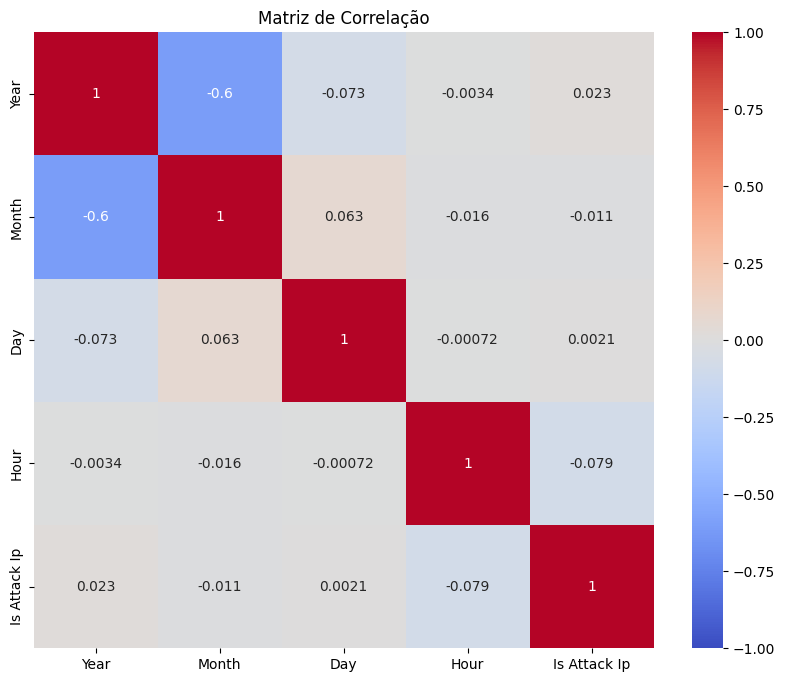

In [89]:
df_time = df.select("Year", "Month", "Day", "Hour","Is Attack Ip")


df_correlation = df_time.toPandas()


correlation_matrix = df_correlation.corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de Correlação')
plt.show()

Podemos observar que as variáveis relativas ao ano, mês dia e hora ,são pouco correlacionadas com a variável alvo

## Variáveis Categóricas

### Variável Browser

In [90]:
contingency_table = df.stat.crosstab("Is Attack Ip", "Browser Name and Version")
contingency_table.show()

#Converting spark contingency_table to pandas DataFrame
contingency_table_df = contingency_table.toPandas()
contingency_table_df = contingency_table_df.set_index('Is Attack Ip_Browser Name and Version')

+-------------------------------------+--------+---------------+---------------+----------------------+-------------+-------------+-------------+-----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------

In [91]:
chi2, p_value, degrees_of_freedom, expected_frequencies = chi2_contingency(contingency_table_df)

# Print the results
print("Chi-Square Statistic:", chi2)
print("P-Value:", p_value)
print("Degrees of Freedom:", degrees_of_freedom)


Chi-Square Statistic: 189920.9078551539
P-Value: 0.0
Degrees of Freedom: 2153


### Variável OS

In [92]:
contingency_table = df.stat.crosstab("Is Attack Ip", "OS Name and Version")
contingency_table.show()

#Converting spark contingency_table to pandas DataFrame
contingency_table_df = contingency_table.toPandas()
contingency_table_df = contingency_table_df.set_index('Is Attack Ip_OS Name and Version')

+--------------------------------+--------+------------+--------------+---------------+------------+-----------------------------+------------+------------+------------+-----------+-----------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+---------+-----------+-------------+-------------+-----------+-------------+-------------+-------------+-------------+-------------+-----------+-------------+-------------+--------------+-----------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+-------------+--------------+-----------+-------------+-----------+-------------+-----------+--------------+-----------+-------------+-------------+-------------+---------------+---------------+-------------+-----------+-------------+-----------+-------------+-----------+-------------+-----------+--------------------+-------------------+-------------------+-----------

In [93]:
chi2, p_value, degrees_of_freedom, expected_frequencies = chi2_contingency(contingency_table_df)

# Print the results
print("Chi-Square Statistic:", chi2)
print("P-Value:", p_value)
print("Degrees of Freedom:", degrees_of_freedom)

Chi-Square Statistic: 120053.9670491205
P-Value: 0.0
Degrees of Freedom: 388


### Variável Device Type

In [94]:
contingency_table = df.stat.crosstab("Is Attack Ip", "Device Type")
contingency_table.show()

#Converting spark contingency_table to pandas DataFrame
contingency_table_df = contingency_table.toPandas()
contingency_table_df = contingency_table_df.set_index('Is Attack Ip_Device Type')

+------------------------+-----+-------+------+------+-------+
|Is Attack Ip_Device Type|  bot|desktop|mobile|tablet|unknown|
+------------------------+-----+-------+------+------+-------+
|                    true| 1318|  11555|137551|  1113|   2784|
|                   false|99971| 385196|843825| 39264|  41030|
+------------------------+-----+-------+------+------+-------+



In [95]:
chi2, p_value, degrees_of_freedom, expected_frequencies = chi2_contingency(contingency_table_df)

# Print the results
print("Chi-Square Statistic:", chi2)
print("P-Value:", p_value)
print("Degrees of Freedom:", degrees_of_freedom)

Chi-Square Statistic: 51821.909824589835
P-Value: 0.0
Degrees of Freedom: 4


### Variável Country

In [96]:
contingency_table = df.stat.crosstab("Is Attack Ip", "Country")
contingency_table.show()

#Converting spark contingency_table to pandas DataFrame
contingency_table_df = contingency_table.toPandas()
contingency_table_df = contingency_table_df.set_index('Is Attack Ip_Country')

+--------------------+---+---+---+---+---+---+---+---+----+---+----+-----+---+---+---+---+---+----+---+---+----+---+---+---+---+---+---+---+---+-----+---+---+---+---+---+----+---+---+---+----+---+---+---+----+---+---+---+---+---+---+----+-----+---+----+---+---+---+---+---+----+----+---+---+---+----+---+-----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+-----+---+---+---+-----+---+----+---+----+---+---+---+----+---+---+---+---+---+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+------+---+---+----+---+---+---+---+---+---+---+-----+---+---+---+---+---+---+---+----+---+-----+---+---+---+---+---+----+----+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+-----+---+------+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+
|Is Attack Ip_Country| AE| AF| AG| AI| AL| AM| AO| AQ|  AR| 

In [97]:
chi2, p_value, degrees_of_freedom, expected_frequencies = chi2_contingency(contingency_table_df)

# Print the results
print("Chi-Square Statistic:", chi2)
print("P-Value:", p_value)
print("Degrees of Freedom:", degrees_of_freedom)

Chi-Square Statistic: 251018.79045696196
P-Value: 0.0
Degrees of Freedom: 216


### Variável ASN

In [98]:
contingency_table = df.stat.crosstab("Is Attack Ip", "ASN")
contingency_table.show()

#Converting spark contingency_table to pandas DataFrame
contingency_table_df = contingency_table.toPandas()
contingency_table_df = contingency_table_df.set_index('Is Attack Ip_ASN')

+----------------+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+---+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+---+-----+-----+-----+------+-----+------+------+------+------+------+------+-----+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-----+-----+------+------+------+------+-----+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+------+-----+-----+------+------+------+------+------+------+------+------+------+-----+------+------+------+------

In [99]:
chi2, p_value, degrees_of_freedom, expected_frequencies = chi2_contingency(contingency_table_df)

# Print the results
print("Chi-Square Statistic:", chi2)
print("P-Value:", p_value)
print("Degrees of Freedom:", degrees_of_freedom)

Chi-Square Statistic: 432013.03238025226
P-Value: 0.0
Degrees of Freedom: 5647


### Variável ip_classification

In [100]:
contingency_table = df.stat.crosstab("Is Attack Ip", "ip_classification")
contingency_table.show()

#Converting spark contingency_table to pandas DataFrame
contingency_table_df = contingency_table.toPandas()
contingency_table_df = contingency_table_df.set_index('Is Attack Ip_ip_classification')

+------------------------------+-------+-------+
|Is Attack Ip_ip_classification|Private| Public|
+------------------------------+-------+-------+
|                          true|  25377| 128944|
|                         false| 339247|1070039|
+------------------------------+-------+-------+



In [101]:
chi2, p_value, degrees_of_freedom, expected_frequencies = chi2_contingency(contingency_table_df)

# Print the results
print("Chi-Square Statistic:", chi2)
print("P-Value:", p_value)
print("Degrees of Freedom:", degrees_of_freedom)

Chi-Square Statistic: 4525.536386919811
P-Value: 0.0
Degrees of Freedom: 1


### Variável Dangerous IP

In [102]:
contingency_table = df.stat.crosstab("Is Attack Ip", "Dangerous IP")
contingency_table.show()

#Converting spark contingency_table to pandas DataFrame
contingency_table_df = contingency_table.toPandas()
contingency_table_df = contingency_table_df.set_index('Is Attack Ip_Dangerous IP')

+-------------------------+-------+------+
|Is Attack Ip_Dangerous IP|  false|  true|
+-------------------------+-------+------+
|                     true|  16977|137344|
|                    false|1409286|     0|
+-------------------------+-------+------+



In [103]:
chi2, p_value, degrees_of_freedom, expected_frequencies = chi2_contingency(contingency_table_df)

# Print the results
print("Chi-Square Statistic:", chi2)
print("P-Value:", p_value)
print("Degrees of Freedom:", degrees_of_freedom)

Chi-Square Statistic: 1375017.679182571
P-Value: 0.0
Degrees of Freedom: 1


### Variável Login Sucessfull

In [105]:
contingency_table = df.stat.crosstab("Is Attack Ip", "Login Successful")
contingency_table.show()

#Converting spark contingency_table to pandas DataFrame
contingency_table_df = contingency_table.toPandas()
contingency_table_df = contingency_table_df.set_index('Is Attack Ip_Login Successful')

+-----------------------------+------+------+
|Is Attack Ip_Login Successful| false|  true|
+-----------------------------+------+------+
|                         true|114285| 40036|
|                        false|823411|585875|
+-----------------------------+------+------+



In [106]:
chi2, p_value, degrees_of_freedom, expected_frequencies = chi2_contingency(contingency_table_df)

# Print the results
print("Chi-Square Statistic:", chi2)
print("P-Value:", p_value)
print("Degrees of Freedom:", degrees_of_freedom)

Chi-Square Statistic: 14152.316675082726
P-Value: 0.0
Degrees of Freedom: 1


Podemos então concluir que as variáveis categóricas são altamente relevantes para a saber se o login é ataque de ip ou não

# Encoding de variáveis categóricas

### Variável Browser

In [107]:
unique_user_agent_count = df.select("Browser Name and Version").distinct().count()

# Show the count
print(f"Number of unique browser: {unique_user_agent_count}")

Number of unique browser: 2154


In [108]:
df = df.withColumn("hashed_browser", F.abs(F.hash("Browser Name and Version")) % 500)

In [109]:
unique_user_agent_count = df.select("hashed_browser").distinct().count()

# Show the count
print(f"Number of unique browser: {unique_user_agent_count}")

Number of unique browser: 497


### Variável OS

In [110]:
unique_user_agent_count = df.select("OS Name and Version").distinct().count()

# Show the count
print(f"Number of unique browser: {unique_user_agent_count}")

Number of unique browser: 389


In [111]:
df = df.withColumn("hashed_OS", F.abs(F.hash("OS Name and Version")) % 100)

In [112]:
unique_user_agent_count = df.select("hashed_OS").distinct().count()

# Show the count
print(f"Number of unique os: {unique_user_agent_count}")

Number of unique os: 99


### Variável Device Type

In [113]:
unique_user_agent_count = df.select("Device Type").distinct().count()

# Show the count
print(f"Number of unique device type: {unique_user_agent_count}")

Number of unique device type: 5


In [114]:
dt_indexer = StringIndexer(inputCol="Device Type", outputCol="dtIndex")

df = dt_indexer.fit(df).transform(df)

In [115]:
onehotencoderdt = OneHotEncoder(inputCol="dtIndex", outputCol="dtohc")
df = onehotencoderdt.fit(df).transform(df)

### Variável Country

In [116]:
unique_user_agent_count = df.select("Country").distinct().count()

# Show the count
print(f"Number of unique Country: {unique_user_agent_count}")

Number of unique Country: 217


In [117]:
df = df.withColumn("hashed_country", F.abs(F.hash("Country")) % 100)

In [118]:
unique_user_agent_count = df.select("hashed_country").distinct().count()

# Show the count
print(f"Number of unique Country: {unique_user_agent_count}")

Number of unique Country: 87


### Variável ASN

In [119]:
unique_user_agent_count = df.select("ASN").distinct().count()

# Show the count
print(f"Number of unique ASN: {unique_user_agent_count}")

Number of unique ASN: 5648


In [120]:
df = df.withColumn("hashed_ASN", F.abs(F.hash("ASN")) % 100)

In [121]:
unique_user_agent_count = df.select("hashed_ASN").distinct().count()

# Show the count
print(f"Number of unique os: {unique_user_agent_count}")

Number of unique os: 100


### Variável ip_classification

In [122]:
unique_user_agent_count = df.select("ip_classification").distinct().count()

# Show the count
print(f"Number of unique os: {unique_user_agent_count}")

Number of unique os: 2


In [123]:
ip_class_indexer = StringIndexer(inputCol="ip_classification", outputCol="ip_class_index")

df = ip_class_indexer.fit(df).transform(df)

In [124]:
onehotencoderdt = OneHotEncoder(inputCol="ip_class_index", outputCol="ip_ohc")
df = onehotencoderdt.fit(df).transform(df)

Para as variáveis com muitas categorias fui utilizado feature hashing para reduzir o número  e codificar as categorias.
Para as restantes foi utilizado one hot encoding.

### Vector Assemble

Escohemos fazer assemble das variáveis consideradas relevantes

In [125]:
df_model = df.select("hashed_ASN", "dtIndex","hashed_OS","hashed_browser","Dangerous IP","ip_class_index","Is Attack IP","Login Successful")

In [126]:
df_model = df_model.withColumn("Is Attack IP", F.col("Is Attack IP").cast("integer"))

In [127]:
df_model.show()

+----------+-------+---------+--------------+------------+--------------+------------+----------------+
|hashed_ASN|dtIndex|hashed_OS|hashed_browser|Dangerous IP|ip_class_index|Is Attack IP|Login Successful|
+----------+-------+---------+--------------+------------+--------------+------------+----------------+
|        53|    1.0|       37|           131|       false|           0.0|           0|            true|
|        53|    0.0|        6|           261|       false|           0.0|           0|            true|
|        53|    0.0|       94|           236|       false|           0.0|           1|           false|
|        84|    0.0|       34|           236|       false|           0.0|           0|           false|
|        32|    0.0|       60|           173|       false|           0.0|           0|           false|
|        53|    4.0|       67|           223|       false|           0.0|           0|            true|
|        84|    0.0|       60|           479|       false|      

In [128]:
featureAssembler = VectorAssembler(inputCols=["hashed_ASN", "dtIndex","hashed_OS","hashed_browser","Dangerous IP","ip_class_index","Login Successful"],outputCol="features")

In [129]:
output = featureAssembler.transform(df_model)
output.select("features","Is Attack IP").show(5)

+--------------------+------------+
|            features|Is Attack IP|
+--------------------+------------+
|[53.0,1.0,37.0,13...|           0|
|[53.0,0.0,6.0,261...|           0|
|(7,[0,2,3],[53.0,...|           1|
|(7,[0,2,3],[84.0,...|           0|
|(7,[0,2,3],[32.0,...|           0|
+--------------------+------------+
only showing top 5 rows



# Exportar Dados

## Base de dados para o modelo

In [130]:
output_logins = "model_db.parquet"
output.write.mode("overwrite").parquet(output_logins)

## Base de dados para a análise exploratória

In [131]:
output_logins = "login.parquet"
df.write.mode("overwrite").parquet(output_logins)